In [4]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from langchain_community.chat_models.tongyi import ChatTongyi

llm = ChatTongyi( # type: ignore
    model="qwen3-1.7b", # 这里用qwen3-0.6b似乎不支持structed_llm
    model_kwargs={
        "temperature": 0.0,
        "enable_thinking": False,
    },
)

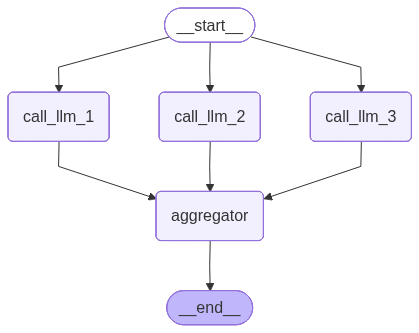

Here's a story, joke, and poem about cats!

STORY:
**Title: The Whispering Shadows**

In the quiet town of Willowbrook, where the trees whispered secrets to the wind and the moonlight danced on the river’s surface, there lived a cat named Miso. He was not a common cat—his fur was a deep, midnight blue that shimmered like the night sky, and his eyes were twin pools of silver, reflecting the world in a way that made even the most seasoned observers pause.

Miso lived in a small cottage at the edge of the forest, nestled between two ancient oaks. The villagers called him "The Shadow," for he often moved through the woods without a sound, as if he were part of the trees themselves. They said he could hear the thoughts of the dead, or perhaps the echoes of the past. But Miso never cared for their tales. He only knew that he was alone, and that the world outside was too loud, too bright, too full of noise.

He had been born in the wild, raised by a reclusive old woman who claimed he was a gu

In [5]:

# Graph state
class State(TypedDict):
    topic: str
    joke: str
    story: str
    poem: str
    combined_output: str


# Nodes
def call_llm_1(state: State):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}


def call_llm_2(state: State):
    """Second LLM call to generate story"""

    msg = llm.invoke(f"Write a story about {state['topic']}")
    return {"story": msg.content}


def call_llm_3(state: State):
    """Third LLM call to generate poem"""

    msg = llm.invoke(f"Write a poem about {state['topic']}")
    return {"poem": msg.content}


def aggregator(state: State):
    """Combine the joke and story into a single output"""

    combined = f"Here's a story, joke, and poem about {state['topic']}!\n\n"
    combined += f"STORY:\n{state['story']}\n\n"
    combined += f"JOKE:\n{state['joke']}\n\n"
    combined += f"POEM:\n{state['poem']}"
    return {"combined_output": combined}


# Build workflow
parallel_builder = StateGraph(State)

# Add nodes
parallel_builder.add_node("call_llm_1", call_llm_1)
parallel_builder.add_node("call_llm_2", call_llm_2)
parallel_builder.add_node("call_llm_3", call_llm_3)
parallel_builder.add_node("aggregator", aggregator)

# Add edges to connect nodes
parallel_builder.add_edge(START, "call_llm_1")
parallel_builder.add_edge(START, "call_llm_2")
parallel_builder.add_edge(START, "call_llm_3")
parallel_builder.add_edge("call_llm_1", "aggregator")
parallel_builder.add_edge("call_llm_2", "aggregator")
parallel_builder.add_edge("call_llm_3", "aggregator")
parallel_builder.add_edge("aggregator", END)
parallel_workflow = parallel_builder.compile()

# Show workflow
display(Image(parallel_workflow.get_graph().draw_mermaid_png()))

# Invoke
state = parallel_workflow.invoke({"topic": "cats"})
print(state["combined_output"])